# Equation of State
This uses the [equation of state](https://github.com/dionhaefner/pyhpc-benchmarks/blob/master/benchmarks/equation_of_state/eos_jax.py) from the [`pyhpc`](https://github.com/dionhaefner/pyhpc-benchmarks/) benchmark.

In [1]:
import os, copy
#ncpu=1
#os.environ['XLA_FLAGS'] = f"--xla_force_host_platform_device_count={ncpu}"
#os.environ["XLA_FLAGS"] = ("--xla_cpu_multi_thread_eigen=false " "intra_op_parallelism_threads=1")
#os.environ['JAX_PLATFORMS'] = "cpu"

UseGPU = True

if UseGPU:
    os.environ['JAX_PLATFORMS'] = "cuda"
    import cupy as np

else:
    os.environ['JAX_PLATFORMS'] = "cpu"
    import numpy as np
#

import numpy
import jax
import sys
import jax.numpy as jnp
from jax import jit, grad, vmap
from jax import random

# This must be enabled when `make_jaxpr` is called, because otherwhise we get problems.
jax.config.update("jax_enable_x64", True)


import timeit
from datetime import datetime
from pickle import dump


import pyhpc
from pyhpc.equation_of_state import get_callable, generate_inputs
from pyhpc.equation_of_state.eos_jax import gsw_dHdT as CALL
from pyhpc.equation_of_state.eos_numpy import gsw_dHdT as gsw_dHdT_NP

import dace


if UseGPU:
    device = dace.DeviceType.GPU
    dace.config.Config.set("compiler", "cpu", "executable", value="/usr/bin/g++-12")
else:
    device = dace.DeviceType.CPU
#

#### Parameter of Benchmarking

In [2]:
repeat, number = 10, 2 #3000, 50

#### The `JAX->SDFG` Translator

In [3]:
from JaxprToSDFG import  JaxprToSDFG
t = JaxprToSDFG()

###### Options for Compilation

In [4]:
_build_type = "Release"
# removing  -ffast-math from DaCe default compiler args in order to support isfinite/isinf/isnan built-ins
_cpu_args = dace.config.Config.get("compiler", "cpu", "args").replace('-ffast-math', '') + ' -fopenmp' + ' -faligned-new'

### Bench Loop

In [5]:
xSizes = numpy.array([5 * i  for i in range(1, 10)])
ySizes = xSizes.copy()
gSizes = numpy.array([5, 10]) #   np.array([50 * i  for i in range(1, 21)])

resTime_sdfg = []
resTime_pf   = []
resTime_jax  = []

usePF = True
useJaxToSDFG = False

simplify = False
auto_opt = False

for gSize in gSizes:
    print(f"Start with size {gSize}")
    # Generate the input that we use
    INP_NP = generate_inputs(gSize)
    INP = [np.array(x)  for x in INP_NP]

    # Generate the SDFG we will use to call
    with jax.disable_jit(disable=True):
        if(useJaxToSDFG):
            JaxprCall = jax.make_jaxpr(CALL)(*INP)
            CallSDFG = t(JaxprCall, simplify=simplify, auto_opt=auto_opt, ret_by_arg=True, device=device)
        #
    #
    with dace.config.temporary_config():
        dace.config.Config.set("compiler", "build_type", value=_build_type)
        dace.config.Config.set("compiler", "cpu", "args", value=_cpu_args)

        if(useJaxToSDFG):
            CallDaCe = CallSDFG.compile()

        # Generate the SDFG that is based on the Python frontend
        if(usePF):
            # We have to do it that way, because otherwise we got some strange errors.
            CallPFProg = dace.program(auto_optimize=auto_opt, recreate_sdfg=True, device=device)(gsw_dHdT_NP)
            CallPFSDFG = CallPFProg.to_sdfg(*INP, simplify=simplify)
            if(False):
                CallPFSDFG = CallPFProg.auto_optimize(CallPFSDFG)
            if(UseGPU):
                CallPFSDFG.apply_gpu_transformations()    
            CallPF   = CallPFSDFG.compile()
        #
    #

    # Now generate the Jax Call
    CallJax = jax.jit(CALL)
    _ = CallJax(*INP_NP).block_until_ready()

    # Now call JAX and SDFG once
    _out = np.zeros_like(INP[0])
    _ = CallJax(*INP_NP).block_until_ready()

    if(useJaxToSDFG):
        _ = CallDaCe(*INP, _out)
        _ = CallDaCe._fast_call(*CallDaCe._lastargs)
    if(usePF):
        _ = CallPF(*INP)
        _ = CallPF._fast_call(*CallPF._lastargs)
    #
    
    # Run JAX
    t_ = timeit.Timer(lambda: CallJax(*INP_NP).block_until_ready() )
    r = numpy.array(t_.repeat(repeat, number))
    resTime_jax.append(r)

    
    # Run Python Frontend
    if(usePF):
        t_ = timeit.Timer(lambda: CallPF._fast_call(*CallPF._lastargs))
        r = numpy.array(t_.repeat(repeat, number))
        resTime_pf.append(r)
    else:
        resTime_pf.append(numpy.zeros(repeat))
    #   

    
    # Run SDFG
    if(useJaxToSDFG):
        t_ = timeit.Timer(lambda: CallDaCe._fast_call(*CallDaCe._lastargs))
        r = numpy.array(t_.repeat(repeat, number))
        resTime_sdfg.append(r)
    else:
        resTime_sdfg.append(numpy.zeros(repeat))
    #   
#

Now = datetime.now()
with open(f'EqOfState__{Now.year}-{Now.month}-{Now.day}_{Now.hour}-{Now.minute}-{Now.second}.pickle', '+bw') as F:
    dump((gSizes, resTime_pf, resTime_jax, resTime_sdfg), F)
#

Start with size 5


/home/quint_essent/git/1_CSCS/dace/dace/codegen/targets/cuda.py:1830: UserWarning: No `gpu_block_size` property specified on map "_Mult__map". Falling back to the configuration entry `compiler.cuda.default_block_size`: 32,1,1. You can either specify the block size to use with the gpu_block_size property, or by adding nested `GPU_ThreadBlock` maps, which map work to individual threads. For more information, see https://spcldace.readthedocs.io/en/latest/optimization/gpu.html
  warnings.warn(
/home/quint_essent/git/1_CSCS/dace/dace/codegen/targets/cuda.py:1830: UserWarning: No `gpu_block_size` property specified on map "_Add__map". Falling back to the configuration entry `compiler.cuda.default_block_size`: 32,1,1. You can either specify the block size to use with the gpu_block_size property, or by adding nested `GPU_ThreadBlock` maps, which map work to individual threads. For more information, see https://spcldace.readthedocs.io/en/latest/optimization/gpu.html
  warnings.warn(
/home/quint

Start with size 10


/home/quint_essent/git/1_CSCS/dace/dace/sdfg/sdfg.py:2191: UserWarning: SDFG "pyhpc_equation_of_state_eos_numpy_gsw_dHdT" is already loaded by another object, recompiling under a different name.
  warnings.warn('SDFG "%s" is already loaded by another object, '


In [6]:
resTime_sdfg_min = numpy.array([r.min()  for r in resTime_sdfg])
resTime_jax_min = numpy.array([r.min()  for r in resTime_jax])
resTime_pf_min = numpy.array([r.min()  for r in resTime_pf])

resTime_sdfg_mean = numpy.array([r.mean()  for r in resTime_sdfg])
resTime_jax_mean = numpy.array([r.mean()  for r in resTime_jax])
resTime_pf_mean = numpy.array([r.mean()  for r in resTime_pf])

resTime_sdfg_std = numpy.array([r.std()  for r in resTime_sdfg])
resTime_jax_std = numpy.array([r.std()  for r in resTime_jax])
resTime_pf_std = numpy.array([r.std()  for r in resTime_pf])

In [7]:
import matplotlib as mpl
from matplotlib import pyplot as plt

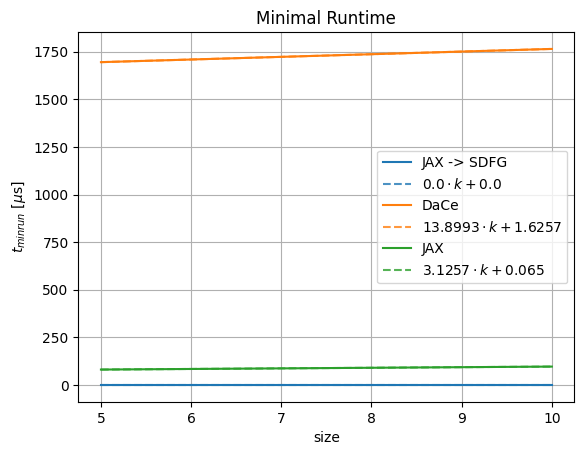

In [9]:
X = numpy.vstack([gSizes, numpy.ones_like(gSizes)]).T

for ID, Time in {'JAX -> SDFG':  resTime_sdfg_min,
                 'DaCe':         resTime_pf_min,
                 'JAX':          resTime_jax_min, }.items():
    plt.plot(gSizes, Time * 1000000 / number, label=ID)
    col = plt.gca().lines[-1].get_color()
    a, b = numpy.linalg.lstsq(X, Time / number, rcond=None)[0]

    Times_ = a * numpy.array(gSizes) + b
    plt.plot(
        gSizes, Times_ * 1000000,
        c=col, linestyle='--', alpha=0.8, 
        label=f'${int(a * (1e6*1e4))/1e4} \\cdot k + {int(b * (1e3*1e4))/1e4}$',
    )
#


plt.legend()
plt.xlabel('size')
plt.ylabel('$t_{min run}$ [$\\mu$s]')
plt.grid(visible=True)
#plt.yscale('log')

plt.title("Minimal Runtime")

plt.show()
